# Flight Predictor Project
#### by Jackie Ramsey

## Purpose of this App
When it comes to traveling, one of the main methods of transportation is through commercial airlines. Air Travel is a significant part of the transportation industry and is used by many. Though this is an efficient method of transportation, one of the problems often encountered are delays in flights. This causes travelers to miss connecting flights or miss events at their destination.  

My main motivation for this project is to decrease this problem by predicting the probability of a delay in the user’s flight. As someone who has been stuck in many airports for hours or overnight before due to delays, I would have been interested in preventing this.  

Being able to find the route and light that suits your needs is the purpose of this project. Users are be able to better gauge what flights they should take in order to arrive at their destination at the expected time.

## The Pipeline
This project is being run and deployed through the Google Cloud Platform and Streamlit.  

1. Ingestion
    * Using Selenium and BeautifulSoup, historical data is being scraped from the [Beaureau of Transportation Statistics](https://www.transtats.bts.gov/DL_SelectFields.aspx?gnoyr_VQ=FGJ&QO_fu146_anzr=b0-gvzr)
    * Fields: [FlightDate, Reporting_Airline, Flight_Number_Reporting_Airline, OriginAirportID, Origin, DestAirportID, Dest, CRSDepTime, DepTime, DepDelay, CRSArrTime, ArrTime, ArrDelay, Cancelled, Diverted, Distance]
    * Timely data is being pulled from this website using Github Actions with the newest month of data 
    * For this project, I am did not scrape all the data from 1987-2023 because 1 month of data has about 700,00 lines!  

2. Storage
    * Since there is so much data, it is uploaded into storage buckets on Google Cloud Storage
    * To parse data, I transfered it to BigQuery and used queries to pull the datasets I wanted to use.

3. Machine Learning
    * Through queries, datasets were fed into local classifiers and trained
    * After the classifier was trained, it was packaged as a pickle file
    * Visualizations and other eda used libraries such as seaborn, matplotlib, etc.

4. Prediction
    * I wanted users to be able to search real flights and predict the delays of these flights, so I looked for free flight apis
    * Most free ones were filled with bugs and did not work, so I signed up for a free trial with Flightlabs
    * The trial ends Sunday, May 14th
    * The request form that the api uses was plugged into the streamlit app, for users to use as the prediction test

5. Deployment
    * Through Streamlit Community, the app is deployed and accessible to all.


## Trials and Errors
There were many dead ends that were discovered as this project was built. Findings a good API to use for future flights was nearly impossible. Most free apis had big problems and bugs that did not work at all. I ended up having to resort to a free trial because I really wanted users to be able to search for real flights.  

Since the data I trained the classifiers on was categorical, there were many problems I ran into. Libraries such as sklearn and tensorflow only was compatible with continuous data and had a complex way of converting categorical data. I did come across the CatBoost library which did not require some kinda of Label Encoder or One Hot Encoder. 

I was also originally going to deploy the app with Heroku but after learning about Streamlit I switched to that.  


## Findings

As seen by the following bar chart, many of the delays were at large airports that has a lot of air traffic.

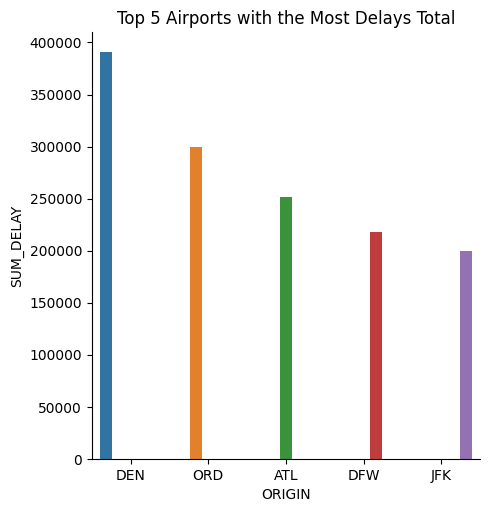

In [5]:
import seaborn as sns
import pandas as pd

df = pd.read_csv("./querying/big_data/origin_delay.csv")
sns.catplot(x="ORIGIN", y="SUM_DELAY", hue="ORIGIN", kind="bar", data=df).set(title='Top 5 Airports with the Most Delays Total')

As seen in the linear regression plot, there is not much of a correlation between distance and delays. In fact the super long flights had less delays in general.

[Text(0.5, 1.0, 'Delay time (min) vs. Distance')]

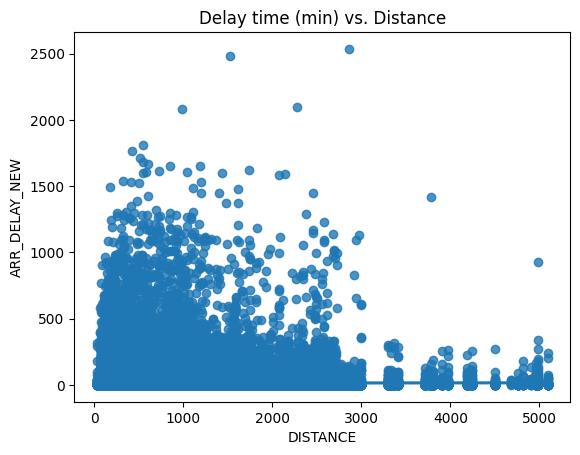

In [6]:
import seaborn as sns
import pandas as pd

df = pd.read_csv("./querying/big_data/distance_delay.csv")
sns.regplot(x="DISTANCE", y="ARR_DELAY_NEW", data=df).set(title='Delay time (min) vs. Distance')

As shown by the following bar plot, the average time when there was a delay hovered around 200 - 400 minutes.

[Text(0.5, 1.0, 'Arrival delay outliers')]

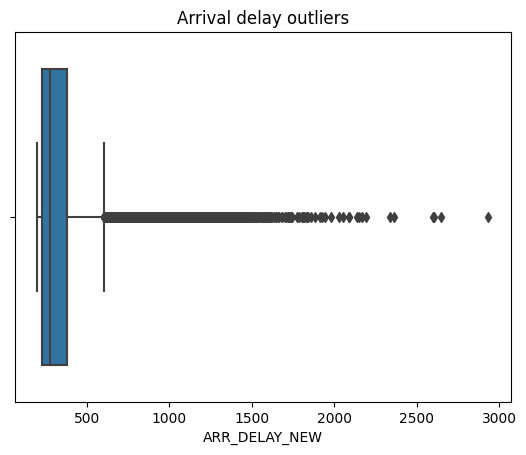

In [11]:
import seaborn as sns
import pandas as pd

df = pd.read_csv("./querying/big_data/outlier_delay.csv")
sns.boxplot(x=df['ARR_DELAY_NEW']).set(title='Arrival delay outliers')

There were almost no diversions in 6 months worth of flights. I thought this would have been a big factor.

Text(0.5, 1.0, 'Diversions for delays')

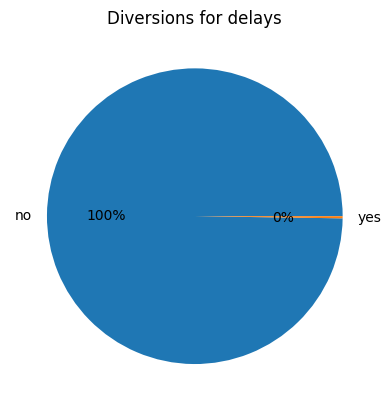

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("./querying/big_data/diverted_delay.csv")

plt.pie(df['COUNT_DIV'], labels=["no", "yes"], autopct='%.0f%%')
plt.title("Diversions for delays")

In the following bar chart, the average departure and arrival delay for each carrier is shown.

<Axes: xlabel='OP_CARRIER'>

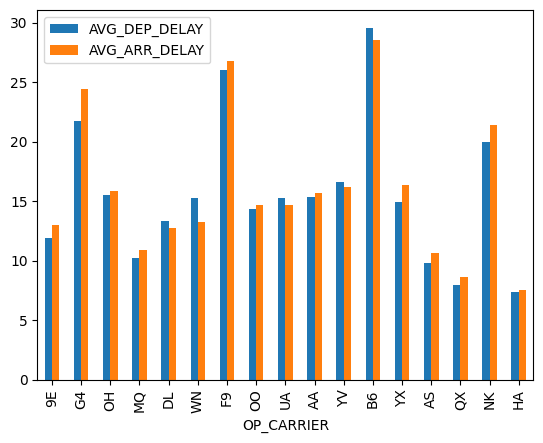

In [6]:
df = pd.read_csv("./querying/big_data/carrier_delay.csv")


# sns.catplot(x="OP_CARRIER", y="VALUES", kind="bar", data=tidy).set(title='Carrier Delays')
df.plot(x='OP_CARRIER', y=['AVG_DEP_DELAY','AVG_ARR_DELAY'], kind='bar')

In [11]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
import pickle
import pandas as pd

print("10-fold Cross Validation on Decision Tree Classifier")
df = pd.read_csv("./querying/big_data/predictor.csv")

classifier = DecisionTreeClassifier()
label_encoder = LabelEncoder()

df_combined = pd.concat([df['OP_CARRIER'], df['OP_CARRIER_FL_NUM'].astype(str), df['ORIGIN'], df['DEST']], axis=0)
label_encoder.fit(df_combined)

df['OP_CARRIER'] = label_encoder.transform(df['OP_CARRIER'])
df['ORIGIN'] = label_encoder.transform(df['ORIGIN'])
df['DEST'] = label_encoder.transform(df['DEST'])

with open('label_encoder.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)

X = df.iloc[:,1:-1]
y =  df.iloc[:,-1:]


n_folds = 10
kf = KFold(n_splits=n_folds)

# Initialize a list to store the accuracy scores for each fold
accuracy_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the classifier on the training data
    classifier.fit(X_train, y_train)
    
    # Predict the labels for the test data
    y_pred = classifier.predict(X_test)
    
    # Calculate accuracy for this fold
    accuracy = accuracy_score(y_test, y_pred)
    
    # Store the accuracy score
    accuracy_scores.append(accuracy)

# Calculate the average accuracy across all folds
average_accuracy = sum(accuracy_scores) / n_folds

# Print the average accuracy
print("Average Accuracy:", average_accuracy)

10-fold Cross Validation on Decision Tree Classifier
Average Accuracy: 0.6164308853824011


It was difficult to get a good accuracy for the classifier for several reasons. There was a huge imabalance in the amount of delays to no delays. There are actually not many delays in general. Also, I was limited to classifying by categorical values because I wante to be able to grab data to predict from real flights. The type of data I could grab from an API was categorical. ex. origin, destination, time. 

## Validation/Testing
The webscraping was validated when called to upload to cloud storage. Contents of download was validated through checking correct headers.  
Querying was tested through smaller queries of 100 limit queries and cross referenced with dataset.  
Prediction accuracy was tested through y_pred, y_test set comparison

## Budget
Billing in GCP:
* Google CLoud Storage: $0.20 per GB per Month
* BigQuery: &0.023 per GB per Month

Flightlabs API:
* free trial... free but after it could be $24 per month


### References
* [Decision Tree Classifier](https://dl.acm.org/doi/fullHtml/10.1145/3497701.3497725#:~:text=The%20comparative%20analysis%20showed%20that,an%20f1%2Dscore%20of%200.8039)
* CPSC322 Decision Tree Classifier
* [Data Science on the Google Platform book](https://github.com/GoogleCloudPlatform/data-science-on-gcp/)
